In [420]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
#     context='paper',
#     font_scale=8/8.8,
    context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [421]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule

/home/pstjohn/Research/rlmolecule/examples/stable_radical_optimization/notebooks


# Initial Results
Eagle is really backed up, so these results are from multiple runs on the debug queue (which has a 1 hr time limit)

In [423]:
import rdkit

In [424]:
# run_id = 'stable_radical_optimization'
from rlmolecule.sql.run_config import RunConfig
run_config = RunConfig('../config/config_eagle_c.yaml')
run_config.run_id

'stable_rad_c_large'

In [425]:
# load the games played
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore

engine = run_config.start_engine()
Session.configure(bind=engine)
session = Session()
df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_config.run_id).statement, session.bind)

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
df = df.sort_values('time_hours')
df_games = df
df_games.reset_index(drop=True, inplace=True)
df_games.head()

,id,run_id,time,raw_reward,scaled_reward,search_statistics,execution_statistics,time_hours
0,c1a811b1-644f-42c4-af35-fd66fafb9886,stable_rad_c_large,2021-06-25 03:53:02.739763,0.0,1.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,"{'total_time': 15.585496425628662, 'execution_...",0.000000
1,7b661aa3-d3ec-44ed-9c47-367d101b047e,stable_rad_c_large,2021-06-25 03:53:03.187607,0.0,0.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,"{'total_time': 15.684531450271606, 'execution_...",0.000124
2,9af523a9-6e31-47c1-97bc-337be6bb4905,stable_rad_c_large,2021-06-25 03:53:03.193143,0.0,1.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,"{'total_time': 15.898685216903687, 'execution_...",0.000126
3,8dae2353-5e0f-4ed4-8b74-fc07aea1aba7,stable_rad_c_large,2021-06-25 03:53:03.233397,0.0,1.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,"{'total_time': 15.451974868774414, 'execution_...",0.000137
4,706b062f-1d18-4316-a25f-be57b9f00571,stable_rad_c_large,2021-06-25 03:53:03.442451,0.0,1.0,[[a323322f10ab649b203db742294f7b2d47a7101e987d...,"{'total_time': 16.136117696762085, 'execution_...",0.000195


In [426]:
df_games.shape

(7148, 8)

In [427]:
df_games.iloc[-1]['execution_statistics']

{'total_time': 605.9965813159943,
 'execution_time': {'get_next_actions': 520.0124328136444,
  'get_value_and_policy': 42.43635368347168,
  '_evaluate': 601.072838306427,
  'calc_reward': 16.93452024459839,
  'maybe_store_state': 1.6238627433776855},
 'execution_count': {'get_next_actions': 6153,
  'get_value_and_policy': 4359,
  '_evaluate': 8500,
  'calc_reward': 1253,
  'maybe_store_state': 347}}

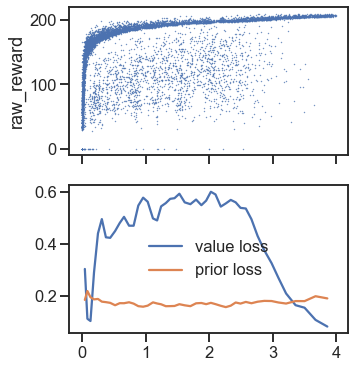

In [467]:
df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_config.run_id).statement, session.bind)
df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
df = df.sort_values('time_hours')

policy_dir = os.path.join(run_config.train_config.get('policy_checkpoint_dir', 'policy_checkpoints'), run_config.run_id)
log = pd.read_csv(os.path.join(policy_dir, "log.csv"))
log['time'] = pd.to_datetime(log.time) - df.time.min()
log['time_hours'] = (log.time).apply(lambda x: x.total_seconds() / 3600)

f, ax = plt.subplots(nrows=2, sharex=True, figsize=(5,6))

ax[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
ax[0].set_ylabel("raw_reward")

ax[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
ax[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')
# ax.set_xlabel("Epoch")
plt.legend()

In [468]:
time = pd.json_normalize(df.execution_statistics.values.tolist())
time_sum = time.sum()
time_sum['execution_time.get_next_actions'] / time_sum['execution_count.get_next_actions']

0.10796788395960016

Text(0, 0.5, 'Game time, minutes')

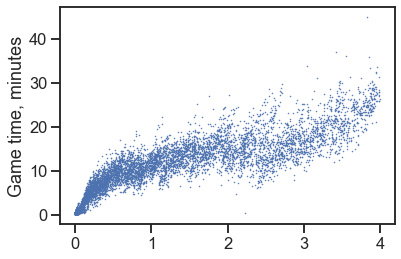

In [469]:
plt.plot(df.time_hours, time.total_time / 60, '.', ms=1)
plt.ylabel('Game time, minutes')

In [470]:
df.iloc[-1]['execution_statistics']

{'total_time': 1580.5236253738403,
 'execution_time': {'get_next_actions': 1499.3183932304382,
  'get_value_and_policy': 52.22012639045715,
  '_evaluate': 1568.050327539444,
  'calc_reward': 3.2301673889160156,
  'maybe_store_state': 3.318272829055786},
 'execution_count': {'get_next_actions': 4744,
  'get_value_and_policy': 3942,
  '_evaluate': 7000,
  'calc_reward': 219,
  'maybe_store_state': 857}}

# Measure the spin, buried volume, and draw the molecule

TODO: Need to join the tables, and unpickle the state to get the smile strings from the state

In [471]:
# look at some of the top rewards
df_rewards = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_config.run_id).order_by(RewardStore.reward.desc()).limit(1000).statement,
                 session.bind)

# df_states = pd.read_sql(session.query(StateStore).filter(StateStore.hash.in_(df_rewards.hash)).statement, session.bind)

In [472]:
session.query(RewardStore).filter_by(run_id=run_config.run_id).count()

6753241

In [474]:
df_rewards['smiles'] = df_rewards.data.apply(lambda x: x['smiles'])
df_rewards = df_rewards.drop_duplicates(subset='smiles')

df_rewards.iloc[0].data

{'max_spin': '0.2271635',
 'spin_buried_vol': '77.44179',
 'ionization_energy': '0.945286214351654',
 'electron_affinity': '-0.36471498012542725',
 'bde': '74.40002',
 'bde_diff': '0.15882874',
 'forced_terminal': True,
 'smiles': 'CC(C)=C([S])/C(=C(/C)CN)C(C)(C)CN'}

In [475]:
df_rewards[df_rewards.smiles.str.contains('c')]

,digest,hash,run_id,time,reward,data,smiles
256,d353423cb0984670229dd29ab74ae1578457b87ab06493...,171766581581737737,stable_rad_c_large,2021-06-25 06:25:13.840166,210.055538,"{'max_spin': '0.31506768', 'spin_buried_vol': ...",CCC(C)(CC)c1c([O])sc(C)c1C=S
296,56698164027e76c14a54248fbafeeca739cda072aff3c3...,1720244536415809055,stable_rad_c_large,2021-06-25 06:33:54.823982,209.905786,"{'max_spin': '0.2708018', 'spin_buried_vol': '...",CCC(C)(C)c1c(N)cccc1/C=C/[O]
586,55e6d335bc4a524837e1656726d5df90ef04087079082e...,204011792542298243,stable_rad_c_large,2021-06-25 06:28:15.107265,209.203976,"{'max_spin': '0.27827293', 'spin_buried_vol': ...",CC(C)(CS)c1c(N)cccc1/C=C/[O]
788,6a20deb2ce3381c5c6baf3ecd8d11993c09867e876cc4b...,3926175880516145611,stable_rad_c_large,2021-06-25 06:25:14.553161,208.861140,"{'max_spin': '0.2899812', 'spin_buried_vol': '...",Cc1sc([O])c(C(C)(C)C(C)(C)N)c1C
904,67af64ab4468d40b4f02f7cb152cc25aa77a017a219bca...,6456301265387280429,stable_rad_c_large,2021-06-25 07:14:55.116700,208.721431,"{'max_spin': '0.30856684', 'spin_buried_vol': ...",CSC(C)(C)c1c([O])sc(C)c1C(C)C


In [476]:
df_rewards[['smiles', 'reward']].head()

,smiles,reward
0,CC(C)=C([S])/C(=C(/C)CN)C(C)(C)CN,216.083613
1,CSC(C)(C)/C(C([O])=C(C)C)=C(/C)CS,214.934933
2,CSCC(/C(S)=C(\[O])S)=C(\C)C(C)(C)C,214.662893
3,CC(C)=C([S])/C(=C(/C)CO)C(C)(C)CO,214.597496
4,C=C(O)/C(=C(\[N]O)SC)C(C)(CC)CC,214.525652


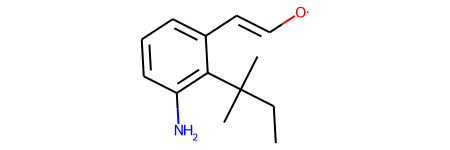

In [466]:
mol = rdkit.Chem.MolFromSmiles(df_rewards['smiles'].iloc[172])
mol

In [418]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import Image

In [414]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

stability_model = tf.keras.models.load_model('/projects/rlmolecule/pstjohn/models/20210214_radical_stability_new_data/', compile=False)
from rlmolecule.molecule.policy.preprocessor import load_preprocessor

preprocessor = load_preprocessor()

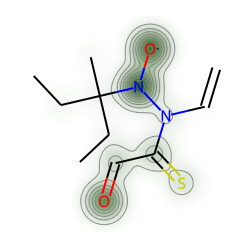

In [419]:
def pred_spins(mol):
    spins, _ = stability_model(
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in preprocessor.construct_feature_matrices(mol).items()})

    return spins.numpy().flatten()

d = rdMolDraw2D.MolDraw2DCairo(250, 250)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
Image(d.GetDrawingText())

# Leftover code from augmenting_reward branch:

In [ ]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

In [ ]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [ ]:
df = rew_df[~rew_df.index.isin(pass_gng.index)].sort_values('real_reward', ascending=False)

In [ ]:
pass_gng.sample(10)

In [ ]:
rew_df[rew_df.real_reward > 200]

In [ ]:
rew_df.real_reward.max()

In [ ]:
plt.hist(rew_df.ie - rew_df.ea, bins=20)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

plt.hist(rew_df.real_reward, label='All radicals', range=(0, 225))
plt.hist(pass_gng.real_reward, label='Pass GNG', color='g', range=(0, 225))
plt.xlabel('Reward')
plt.ylabel('Frequency')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [ ]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [ ]:
# Load the game buffer
with psycopg2.connect(**config.dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
# Load the policy training history
try:
    log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
    log['time'] = pd.to_datetime(log.time)
except Exception:
    log = None

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

if log is not None:
    log['time_hours'] = (log.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

df = df.sort_values('time_hours')

fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(2.75, 2.5), dpi=150)

axs[0].plot(df.time_hours, df.real_reward, '.', ms=.75, label='games')
axs[0].plot(df.time_hours, df.real_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

if log is not None:
    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0.3, bbox_to_anchor=(1., 1.1), markerscale=10)
axs[1].legend(ncol=2, borderpad=0, borderaxespad=0.3)

axs[0].set_ylim([0, 250])

axs[0].set_ylabel('Reward')
axs[1].set_ylabel('Policy Training')
axs[1].set_xlabel('Time (hours)')

axs[1].set_ylim([0, .7])
axs[1].set_xlim([-.01, 4])

plt.tight_layout()
sns.despine(offset=5, trim=True)
# plt.savefig('20210204_policy_loss.svg')

In [ ]:
with psycopg2.connect(**config.dbparams) as conn:
    experiment_ids = pd.read_sql_query("select distinct experiment_id from {}_game".format(config.sql_basename), conn)
    
experiment_ids

In [ ]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**config.dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

In [ ]:
rew_df.sort_values('real_reward', ascending=False).head(20)

In [ ]:
stable_df = pd.read_csv('/home/pstjohn/Research/20200608_redox_calculations/stable_radicals/spin-charges-bur-vol-stable-radicals-all-atoms-with-smi.csv')

stable_df_noH = stable_df[~stable_df['atom-sym-idx'].str.startswith('H')]
stable_df['fractional_spin'] = stable_df_noH.groupby('File')['spin-density'].transform(lambda x: x.abs() / x.abs().sum())

stable_idx_max_spin = stable_df.groupby('File').fractional_spin.idxmax()
stable_max_spin = stable_df.loc[stable_idx_max_spin]

In [ ]:
from rdkit import Chem

In [ ]:
stable_df['smiles'] = stable_df.Smiles.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [ ]:
rew_df[rew_df.smiles.isin(stable_df.smiles)]

In [ ]:
pass_gng = rew_df[(rew_df.bde < 80) & (rew_df.bde > 60) &
                  (rew_df.ie < 1.2) & (rew_df.ea > -.5) &
                  ((rew_df.ie - rew_df.ea) > 1) &
                  ((rew_df.buried_vol + 50 * (1 - rew_df.max_spin)) > 100.)]

In [ ]:
pass_gng.shape

In [ ]:
pass_gng.to_csv('20210109_gng_radicals.csv.gz', compression='gzip')

In [ ]:
from reward import redox_model, predict

In [ ]:
from alphazero.node import Node

In [ ]:
import tensorflow as tf

In [ ]:
def pred_redox(smiles):
    return predict(redox_model,
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(rdkit.Chem.MolFromSmiles(smiles)).policy_inputs.items()}).numpy().flatten()

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
redox = pass_gng.smiles.progress_apply(pred_redox)

In [ ]:
plt.plot(np.vstack(redox.values)[:, 0], pass_gng.ie, '.')

In [ ]:
(pass_gng.ie - np.vstack(redox.values)[:, 0]).abs().mean()

In [ ]:
Node(rdkit.Chem.MolFromSmiles('CC(=S)C1=C(C)[CH]CCC1(C)C')).policy_inputs

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1, label='All radicals')
    
    ax.plot(stable_max_spin[stable_max_spin['atom-sym'] == atom]['fractional_spin'],
            stable_max_spin[stable_max_spin['atom-sym'] == atom]['bur-vol'],
            '.', label='Experimentally stable')
    
    ax.plot(pass_gng[pass_gng.atom_type == atom]['max_spin'],
            pass_gng[pass_gng.atom_type == atom]['buried_vol'], '.', ms=1, label='Pass GNG')
    
    ax.set_title(atom)
    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12, markerscale=2)
sns.despine()    

In [ ]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(rew_df['ea'], rew_df['ie'], '.', ms=1, alpha=.1)
ax.plot(pass_gng['ea'], pass_gng['ie'], '.', ms=1, color='g')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 2])

ax.axvspan(-.5, .2, facecolor='.8', edgecolor='none')
ax.axhspan(.5, 1.2, facecolor='.8', edgecolor='none')

ax.set_xlabel(r'$E_{1/2}^o$, EA (V)')
ax.set_ylabel(r'$E_{1/2}^o$, IE (V)')

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

sns.kdeplot(rew_df.bde, label='All radicals')
sns.kdeplot(pass_gng.bde, label='Pass GNG', color='g')
plt.xlabel('BDE')
plt.ylabel('Frequency')

In [ ]:
df = rew_df[~rew_df.index.isin(pass_gng.index)].sort_values('real_reward', ascending=False)

In [ ]:
pass_gng.sample(10)

In [ ]:
rew_df[rew_df.real_reward > 200]

In [ ]:
rew_df.real_reward.max()

In [ ]:
plt.hist(rew_df.ie - rew_df.ea, bins=20)

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

plt.hist(rew_df.real_reward, label='All radicals', range=(0, 225))
plt.hist(pass_gng.real_reward, label='Pass GNG', color='g', range=(0, 225))
plt.xlabel('Reward')
plt.ylabel('Frequency')

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [ ]:
from reward import predict, stability_model
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(stability_model, 
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [ ]:
# Code for raster image drawing
import rdkit

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from IPython.display import SVG

In [ ]:
row = pass_gng.sample(1, random_state=5).iloc[0]
mol = Chem.MolFromSmiles(row.smiles)

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())